<a href="https://colab.research.google.com/github/mafaldasalomao/Transfering_learning_TF-ExtractFeatures/blob/main/04_transfering_learning_TF_partI_Feature_extract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import zipfile
#download  the data
# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzip the downloaded data
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()


--2022-10-07 20:53:22--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   133MB/s    in 1.2s    

2022-10-07 20:53:24 (133 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
#how many images in each flder?
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories in {len(filenames)} in the {dirpath}.")

There are 2 directories in 0 in the 10_food_classes_10_percent.
There are 10 directories in 0 in the 10_food_classes_10_percent/test.
There are 0 directories in 250 in the 10_food_classes_10_percent/test/chicken_wings.
There are 0 directories in 250 in the 10_food_classes_10_percent/test/steak.
There are 0 directories in 250 in the 10_food_classes_10_percent/test/hamburger.
There are 0 directories in 250 in the 10_food_classes_10_percent/test/fried_rice.
There are 0 directories in 250 in the 10_food_classes_10_percent/test/ice_cream.
There are 0 directories in 250 in the 10_food_classes_10_percent/test/chicken_curry.
There are 0 directories in 250 in the 10_food_classes_10_percent/test/ramen.
There are 0 directories in 250 in the 10_food_classes_10_percent/test/sushi.
There are 0 directories in 250 in the 10_food_classes_10_percent/test/grilled_salmon.
There are 0 directories in 250 in the 10_food_classes_10_percent/test/pizza.
There are 10 directories in 0 in the 10_food_classes_10_pe

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")


Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [23]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_call = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_call

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [2]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [14]:
#Create model function to create model from url

def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  feature_extractor_layer = hub.KerasLayer(model_url,
                                         trainable=False,
                                         name="feature_extraction_layer",
                                         input_shape=IMAGE_SHAPE+(3,))
  #Create our model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
  return model

In [12]:
train_data.num_classes

10

In [15]:
#create resnet model
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

In [18]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [17]:
# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [24]:
# Fit the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20221007-210558
Epoch 1/5
24/24 [==============================] - 30s 753ms/step - loss: 2.0445 - accuracy: 0.3373 - val_loss: 1.2175 - val_accuracy: 0.6104
Epoch 2/5
24/24 [==============================] - 20s 874ms/step - loss: 0.9320 - accuracy: 0.7053 - val_loss: 0.8531 - val_accuracy: 0.7308
Epoch 3/5
24/24 [==============================] - 16s 703ms/step - loss: 0.6410 - accuracy: 0.8080 - val_loss: 0.7505 - val_accuracy: 0.7712
Epoch 4/5
24/24 [==============================] - 20s 857ms/step - loss: 0.4922 - accuracy: 0.8707 - val_loss: 0.7142 - val_accuracy: 0.7664
Epoch 5/5
24/24 [==============================] - 16s 682ms/step - loss: 0.4038 - accuracy: 0.9053 - val_loss: 0.6761 - val_accuracy: 0.7776


In [25]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

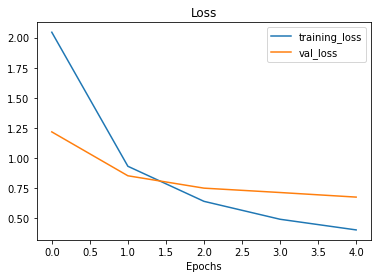

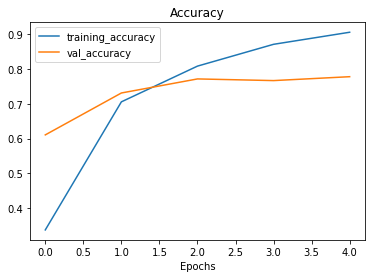

In [26]:
plot_loss_curves(resnet_history)


In [28]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20221007-210829
Epoch 1/5
24/24 [==============================] - 34s 1s/step - loss: 1.8456 - accuracy: 0.4480 - val_loss: 1.3004 - val_accuracy: 0.7240
Epoch 2/5
24/24 [==============================] - 16s 705ms/step - loss: 1.0551 - accuracy: 0.7653 - val_loss: 0.8716 - val_accuracy: 0.8156
Epoch 3/5
24/24 [==============================] - 15s 639ms/step - loss: 0.7516 - accuracy: 0.8400 - val_loss: 0.6941 - val_accuracy: 0.8456
Epoch 4/5
24/24 [==============================] - 16s 669ms/step - loss: 0.6048 - accuracy: 0.8760 - val_loss: 0.6114 - val_accuracy: 0.8568
Epoch 5/5
24/24 [==============================] - 17s 718ms/step - loss: 0.5073 - accuracy: 0.8933 - val_loss: 0.5602 - val_accuracy: 0.8636


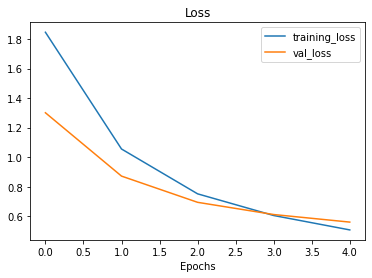

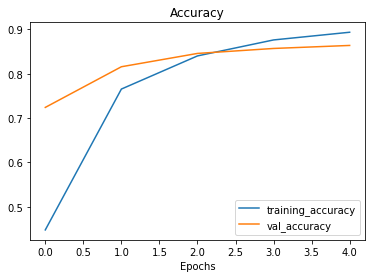

In [29]:
plot_loss_curves(efficientnet_history)

In [30]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=tHOQPO34Rjnrf2fiLAhuMvsjxZhx8U&prompt=consent&access_type=off

In [31]:
# Check out experiments
!tensorboard dev list

https://tensorboard.dev/experiment/FNQWW9k7SYyadyuZGD46Yg/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   FNQWW9k7SYyadyuZGD46Yg
	Created              2022-10-07 21:26:38 (56 seconds ago)
	Updated              2022-10-07 21:26:40 (54 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  5918783
Total: 1 experiment(s)


In [32]:
# Delete an experiment
!tensorboard dev delete --experiment_id FNQWW9k7SYyadyuZGD46Yg

Deleted experiment FNQWW9k7SYyadyuZGD46Yg.


In [33]:
# Check to see if experiments still exist
!tensorboard dev list

No experiments. Use `tensorboard dev upload` to get started.
